In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


In [2]:
#!unzip atMost700.zip

In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Dataset folders 
dataset_dir = 'atMost700'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

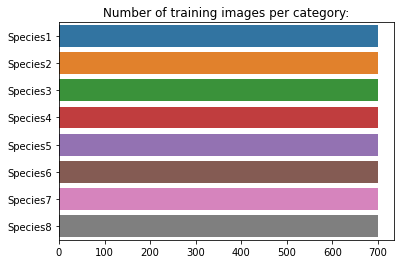

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=90,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [8]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 5600 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [9]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
Label: 6
Class name: Species7


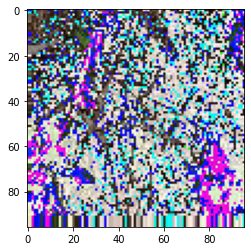

In [10]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [11]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

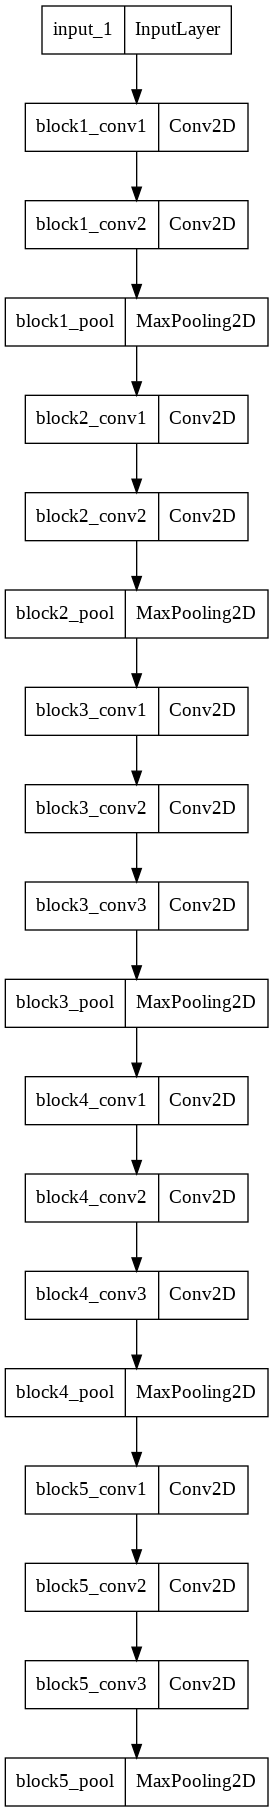

In [12]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [13]:
input_shape = (96, 96, 3)
epochs = 200

In [14]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [15]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [16]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
175/175 [==============================] - ETA: 0s - loss: 3.6954 - accuracy: 0.3448 - precision: 0.4216 - recall: 0.2280

175/175 [==============================] - 1106s 6s/step - loss: 3.6954 - accuracy: 0.3448 - precision: 0.4216 - recall: 0.2280 - val_loss: 1.5667 - val_accuracy: 0.4118 - val_precision: 0.5702 - val_recall: 0.2543
Epoch 2/200
175/175 [==============================] - ETA: 0s - loss: 1.5997 - accuracy: 0.4082 - precision: 0.5862 - recall: 0.2284

175/175 [==============================] - 29s 164ms/step - loss: 1.5997 - accuracy: 0.4082 - precision: 0.5862 - recall: 0.2284 - val_loss: 1.4125 - val_accuracy: 0.4364 - val_precision: 0.6000 - val_recall: 0.2960
Epoch 3/200
175/175 [==============================] - ETA: 0s - loss: 1.4596 - accuracy: 0.4427 - precision: 0.6157 - recall: 0.2589

175/175 [==============================] - 28s 162ms/step - loss: 1.4596 - accuracy: 0.4427 - precision: 0.6157 - recall: 0.2589 - val_loss: 1.3783 - val_accuracy: 0.4440 - val_precision: 0.6908 - val_recall: 0.2713
Epoch 4/200
175/175 [==============================] - ETA: 0s - loss: 1.3746 - accuracy: 0.4688 - precision: 0.6392 - recall: 0.2845

175/175 [==============================] - 29s 165ms/step - loss: 1.3746 - accuracy: 0.4688 - precision: 0.6392 - recall: 0.2845 - val_loss: 1.3510 - val_accuracy: 0.4820 - val_precision: 0.6203 - val_recall: 0.3472
Epoch 5/200
175/175 [==============================] - ETA: 0s - loss: 1.3388 - accuracy: 0.4884 - precision: 0.6534 - recall: 0.3171

175/175 [==============================] - 28s 160ms/step - loss: 1.3388 - accuracy: 0.4884 - precision: 0.6534 - recall: 0.3171 - val_loss: 1.2394 - val_accuracy: 0.4991 - val_precision: 0.6729 - val_recall: 0.3435
Epoch 6/200
175/175 [==============================] - ETA: 0s - loss: 1.2898 - accuracy: 0.5238 - precision: 0.6781 - recall: 0.3450

175/175 [==============================] - 28s 162ms/step - loss: 1.2898 - accuracy: 0.5238 - precision: 0.6781 - recall: 0.3450 - val_loss: 1.1613 - val_accuracy: 0.5237 - val_precision: 0.6827 - val_recall: 0.4042
Epoch 7/200
175/175 [==============================] - ETA: 0s - loss: 1.2530 - accuracy: 0.5318 - precision: 0.6907 - recall: 0.3689

175/175 [==============================] - 28s 161ms/step - loss: 1.2530 - accuracy: 0.5318 - precision: 0.6907 - recall: 0.3689 - val_loss: 1.1887 - val_accuracy: 0.5161 - val_precision: 0.6623 - val_recall: 0.3871
Epoch 8/200
175/175 [==============================] - ETA: 0s - loss: 1.1828 - accuracy: 0.5573 - precision: 0.7090 - recall: 0.4007

175/175 [==============================] - 28s 162ms/step - loss: 1.1828 - accuracy: 0.5573 - precision: 0.7090 - recall: 0.4007 - val_loss: 1.1809 - val_accuracy: 0.5446 - val_precision: 0.6726 - val_recall: 0.4288
Epoch 9/200
175/175 [==============================] - ETA: 0s - loss: 1.1834 - accuracy: 0.5537 - precision: 0.7008 - recall: 0.4029

175/175 [==============================] - 28s 162ms/step - loss: 1.1834 - accuracy: 0.5537 - precision: 0.7008 - recall: 0.4029 - val_loss: 1.3415 - val_accuracy: 0.5408 - val_precision: 0.6317 - val_recall: 0.4459
Epoch 10/200
175/175 [==============================] - ETA: 0s - loss: 1.1672 - accuracy: 0.5666 - precision: 0.7036 - recall: 0.4150

175/175 [==============================] - 28s 159ms/step - loss: 1.1672 - accuracy: 0.5666 - precision: 0.7036 - recall: 0.4150 - val_loss: 1.1836 - val_accuracy: 0.5522 - val_precision: 0.6756 - val_recall: 0.3833
Epoch 11/200
175/175 [==============================] - ETA: 0s - loss: 1.1245 - accuracy: 0.5796 - precision: 0.7180 - recall: 0.4355

175/175 [==============================] - 28s 160ms/step - loss: 1.1245 - accuracy: 0.5796 - precision: 0.7180 - recall: 0.4355 - val_loss: 1.1917 - val_accuracy: 0.5731 - val_precision: 0.6667 - val_recall: 0.4478
Epoch 12/200
175/175 [==============================] - ETA: 0s - loss: 1.1368 - accuracy: 0.5829 - precision: 0.7262 - recall: 0.4363

175/175 [==============================] - 28s 163ms/step - loss: 1.1368 - accuracy: 0.5829 - precision: 0.7262 - recall: 0.4363 - val_loss: 1.1452 - val_accuracy: 0.5693 - val_precision: 0.7026 - val_recall: 0.4573
Epoch 13/200
175/175 [==============================] - ETA: 0s - loss: 1.1029 - accuracy: 0.5807 - precision: 0.7215 - recall: 0.4441

175/175 [==============================] - 28s 162ms/step - loss: 1.1029 - accuracy: 0.5807 - precision: 0.7215 - recall: 0.4441 - val_loss: 1.1256 - val_accuracy: 0.5674 - val_precision: 0.6774 - val_recall: 0.4383
Epoch 14/200
175/175 [==============================] - ETA: 0s - loss: 1.1049 - accuracy: 0.5927 - precision: 0.7336 - recall: 0.4548

175/175 [==============================] - 28s 160ms/step - loss: 1.1049 - accuracy: 0.5927 - precision: 0.7336 - recall: 0.4548 - val_loss: 1.1448 - val_accuracy: 0.5712 - val_precision: 0.6882 - val_recall: 0.4440
Epoch 15/200
175/175 [==============================] - ETA: 0s - loss: 1.0855 - accuracy: 0.5923 - precision: 0.7254 - recall: 0.4552

175/175 [==============================] - 28s 161ms/step - loss: 1.0855 - accuracy: 0.5923 - precision: 0.7254 - recall: 0.4552 - val_loss: 1.1284 - val_accuracy: 0.5712 - val_precision: 0.7147 - val_recall: 0.4516
Epoch 16/200
175/175 [==============================] - ETA: 0s - loss: 1.0717 - accuracy: 0.6093 - precision: 0.7369 - recall: 0.4677

175/175 [==============================] - 27s 157ms/step - loss: 1.0717 - accuracy: 0.6093 - precision: 0.7369 - recall: 0.4677 - val_loss: 1.1576 - val_accuracy: 0.5522 - val_precision: 0.6784 - val_recall: 0.4402
Epoch 17/200
175/175 [==============================] - ETA: 0s - loss: 1.0590 - accuracy: 0.6070 - precision: 0.7382 - recall: 0.4698

175/175 [==============================] - 28s 161ms/step - loss: 1.0590 - accuracy: 0.6070 - precision: 0.7382 - recall: 0.4698 - val_loss: 1.0646 - val_accuracy: 0.5977 - val_precision: 0.7413 - val_recall: 0.4459
Epoch 18/200
175/175 [==============================] - ETA: 0s - loss: 1.0591 - accuracy: 0.6075 - precision: 0.7401 - recall: 0.4775

175/175 [==============================] - 28s 159ms/step - loss: 1.0591 - accuracy: 0.6075 - precision: 0.7401 - recall: 0.4775 - val_loss: 1.0911 - val_accuracy: 0.5731 - val_precision: 0.6791 - val_recall: 0.4497
Epoch 19/200
175/175 [==============================] - ETA: 0s - loss: 1.0661 - accuracy: 0.5998 - precision: 0.7331 - recall: 0.4759

175/175 [==============================] - 28s 160ms/step - loss: 1.0661 - accuracy: 0.5998 - precision: 0.7331 - recall: 0.4759 - val_loss: 1.0891 - val_accuracy: 0.5939 - val_precision: 0.7171 - val_recall: 0.4763
Epoch 20/200
175/175 [==============================] - ETA: 0s - loss: 1.0674 - accuracy: 0.6045 - precision: 0.7264 - recall: 0.4812

175/175 [==============================] - 28s 159ms/step - loss: 1.0674 - accuracy: 0.6045 - precision: 0.7264 - recall: 0.4812 - val_loss: 1.0988 - val_accuracy: 0.5503 - val_precision: 0.6885 - val_recall: 0.4194
Epoch 21/200
175/175 [==============================] - ETA: 0s - loss: 1.0362 - accuracy: 0.6134 - precision: 0.7406 - recall: 0.4843

175/175 [==============================] - 28s 162ms/step - loss: 1.0362 - accuracy: 0.6134 - precision: 0.7406 - recall: 0.4843 - val_loss: 1.0876 - val_accuracy: 0.5731 - val_precision: 0.6880 - val_recall: 0.4478
Epoch 22/200
175/175 [==============================] - ETA: 0s - loss: 1.0327 - accuracy: 0.6200 - precision: 0.7454 - recall: 0.4966

175/175 [==============================] - 28s 160ms/step - loss: 1.0327 - accuracy: 0.6200 - precision: 0.7454 - recall: 0.4966 - val_loss: 1.2665 - val_accuracy: 0.5332 - val_precision: 0.6033 - val_recall: 0.4156
Epoch 23/200
175/175 [==============================] - ETA: 0s - loss: 1.0414 - accuracy: 0.6198 - precision: 0.7415 - recall: 0.4938

175/175 [==============================] - 28s 162ms/step - loss: 1.0414 - accuracy: 0.6198 - precision: 0.7415 - recall: 0.4938 - val_loss: 1.0422 - val_accuracy: 0.5731 - val_precision: 0.6991 - val_recall: 0.4497
Epoch 24/200
175/175 [==============================] - ETA: 0s - loss: 1.0281 - accuracy: 0.6311 - precision: 0.7517 - recall: 0.5013

175/175 [==============================] - 28s 159ms/step - loss: 1.0281 - accuracy: 0.6311 - precision: 0.7517 - recall: 0.5013 - val_loss: 1.0644 - val_accuracy: 0.5958 - val_precision: 0.7135 - val_recall: 0.4630
Epoch 25/200
175/175 [==============================] - ETA: 0s - loss: 1.0176 - accuracy: 0.6295 - precision: 0.7555 - recall: 0.4977

175/175 [==============================] - 28s 162ms/step - loss: 1.0176 - accuracy: 0.6295 - precision: 0.7555 - recall: 0.4977 - val_loss: 1.0698 - val_accuracy: 0.5731 - val_precision: 0.6904 - val_recall: 0.4782
Epoch 26/200
175/175 [==============================] - ETA: 0s - loss: 1.0354 - accuracy: 0.6280 - precision: 0.7470 - recall: 0.4950

175/175 [==============================] - 28s 159ms/step - loss: 1.0354 - accuracy: 0.6280 - precision: 0.7470 - recall: 0.4950 - val_loss: 1.0257 - val_accuracy: 0.6015 - val_precision: 0.7066 - val_recall: 0.4706
Epoch 27/200
175/175 [==============================] - ETA: 0s - loss: 1.0163 - accuracy: 0.6304 - precision: 0.7617 - recall: 0.5045

175/175 [==============================] - 28s 162ms/step - loss: 1.0163 - accuracy: 0.6304 - precision: 0.7617 - recall: 0.5045 - val_loss: 1.0966 - val_accuracy: 0.5958 - val_precision: 0.7003 - val_recall: 0.4744
Epoch 28/200
175/175 [==============================] - ETA: 0s - loss: 0.9907 - accuracy: 0.6325 - precision: 0.7578 - recall: 0.5086

175/175 [==============================] - 28s 159ms/step - loss: 0.9907 - accuracy: 0.6325 - precision: 0.7578 - recall: 0.5086 - val_loss: 1.0783 - val_accuracy: 0.5977 - val_precision: 0.7064 - val_recall: 0.4611
Epoch 29/200
175/175 [==============================] - ETA: 0s - loss: 0.9835 - accuracy: 0.6420 - precision: 0.7662 - recall: 0.5227

175/175 [==============================] - 28s 161ms/step - loss: 0.9835 - accuracy: 0.6420 - precision: 0.7662 - recall: 0.5227 - val_loss: 1.1915 - val_accuracy: 0.5787 - val_precision: 0.6585 - val_recall: 0.4573
Epoch 30/200
175/175 [==============================] - ETA: 0s - loss: 1.0076 - accuracy: 0.6330 - precision: 0.7530 - recall: 0.5079

175/175 [==============================] - 28s 160ms/step - loss: 1.0076 - accuracy: 0.6330 - precision: 0.7530 - recall: 0.5079 - val_loss: 1.0590 - val_accuracy: 0.6034 - val_precision: 0.7151 - val_recall: 0.4858
Epoch 31/200
175/175 [==============================] - ETA: 0s - loss: 1.0107 - accuracy: 0.6271 - precision: 0.7473 - recall: 0.4986

175/175 [==============================] - 28s 162ms/step - loss: 1.0107 - accuracy: 0.6271 - precision: 0.7473 - recall: 0.4986 - val_loss: 1.1529 - val_accuracy: 0.5731 - val_precision: 0.6930 - val_recall: 0.4668
Epoch 32/200
175/175 [==============================] - ETA: 0s - loss: 0.9837 - accuracy: 0.6305 - precision: 0.7567 - recall: 0.5120

175/175 [==============================] - 28s 159ms/step - loss: 0.9837 - accuracy: 0.6305 - precision: 0.7567 - recall: 0.5120 - val_loss: 1.0596 - val_accuracy: 0.5844 - val_precision: 0.7437 - val_recall: 0.4459
Epoch 33/200
175/175 [==============================] - ETA: 0s - loss: 1.0037 - accuracy: 0.6270 - precision: 0.7486 - recall: 0.5109

175/175 [==============================] - 28s 162ms/step - loss: 1.0037 - accuracy: 0.6270 - precision: 0.7486 - recall: 0.5109 - val_loss: 1.0207 - val_accuracy: 0.5825 - val_precision: 0.7601 - val_recall: 0.4630
Epoch 34/200
175/175 [==============================] - ETA: 0s - loss: 0.9840 - accuracy: 0.6416 - precision: 0.7640 - recall: 0.5191

175/175 [==============================] - 28s 158ms/step - loss: 0.9840 - accuracy: 0.6416 - precision: 0.7640 - recall: 0.5191 - val_loss: 1.0722 - val_accuracy: 0.5750 - val_precision: 0.7357 - val_recall: 0.4649
Epoch 35/200
175/175 [==============================] - ETA: 0s - loss: 0.9835 - accuracy: 0.6354 - precision: 0.7645 - recall: 0.5118

175/175 [==============================] - 28s 161ms/step - loss: 0.9835 - accuracy: 0.6354 - precision: 0.7645 - recall: 0.5118 - val_loss: 1.0672 - val_accuracy: 0.5920 - val_precision: 0.7155 - val_recall: 0.4820
Epoch 36/200
175/175 [==============================] - ETA: 0s - loss: 0.9822 - accuracy: 0.6348 - precision: 0.7567 - recall: 0.5211

175/175 [==============================] - 28s 159ms/step - loss: 0.9822 - accuracy: 0.6348 - precision: 0.7567 - recall: 0.5211 - val_loss: 1.0568 - val_accuracy: 0.5958 - val_precision: 0.7179 - val_recall: 0.4877
Epoch 37/200
175/175 [==============================] - ETA: 0s - loss: 0.9482 - accuracy: 0.6511 - precision: 0.7722 - recall: 0.5296

175/175 [==============================] - 28s 161ms/step - loss: 0.9482 - accuracy: 0.6511 - precision: 0.7722 - recall: 0.5296 - val_loss: 1.0482 - val_accuracy: 0.6034 - val_precision: 0.6984 - val_recall: 0.5009
Epoch 38/200
175/175 [==============================] - ETA: 0s - loss: 0.9790 - accuracy: 0.6471 - precision: 0.7720 - recall: 0.5271

175/175 [==============================] - 28s 160ms/step - loss: 0.9790 - accuracy: 0.6471 - precision: 0.7720 - recall: 0.5271 - val_loss: 1.0675 - val_accuracy: 0.6034 - val_precision: 0.6989 - val_recall: 0.4801
Epoch 39/200
175/175 [==============================] - ETA: 0s - loss: 0.9815 - accuracy: 0.6329 - precision: 0.7576 - recall: 0.5229

175/175 [==============================] - 28s 159ms/step - loss: 0.9815 - accuracy: 0.6329 - precision: 0.7576 - recall: 0.5229 - val_loss: 1.1510 - val_accuracy: 0.5674 - val_precision: 0.6989 - val_recall: 0.4668
Epoch 40/200
175/175 [==============================] - ETA: 0s - loss: 0.9702 - accuracy: 0.6489 - precision: 0.7687 - recall: 0.5366

175/175 [==============================] - 28s 162ms/step - loss: 0.9702 - accuracy: 0.6489 - precision: 0.7687 - recall: 0.5366 - val_loss: 1.0876 - val_accuracy: 0.5636 - val_precision: 0.6799 - val_recall: 0.4554


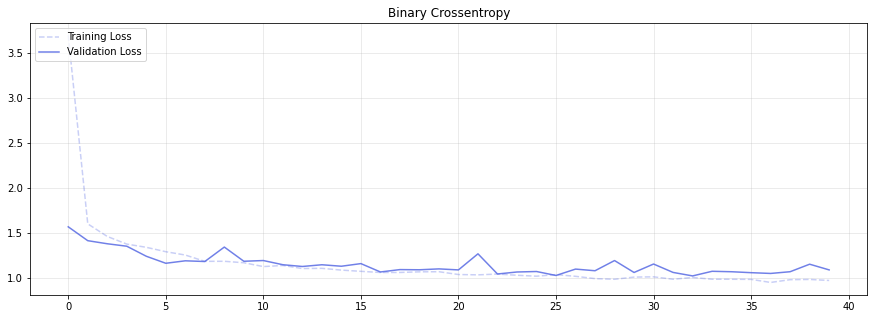

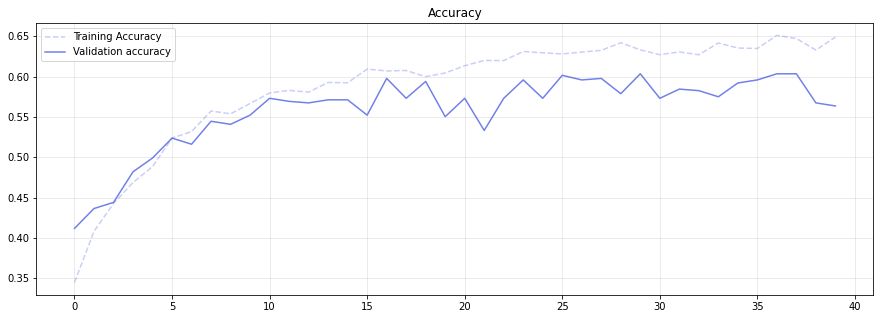

In [17]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [18]:
tl_model.save('Vgg16/FineFineTuning_v1')

In [19]:
tl_model = tfk.models.load_model('Vgg16/FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [20]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [21]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0       

In [22]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [23]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
175/175 [==============================] - 26s 136ms/step - loss: 1.2314 - accuracy: 0.5641 - precision_1: 0.7079 - recall_1: 0.4184 - val_loss: 1.2013 - val_accuracy: 0.5693 - val_precision_1: 0.6425 - val_recall_1: 0.5047
Epoch 2/200
175/175 [==============================] - 23s 132ms/step - loss: 0.9929 - accuracy: 0.6448 - precision_1: 0.7703 - recall_1: 0.5198 - val_loss: 0.9064 - val_accuracy: 0.6584 - val_precision_1: 0.7702 - val_recall_1: 0.5598
Epoch 3/200
175/175 [==============================] - 23s 132ms/step - loss: 0.8746 - accuracy: 0.6898 - precision_1: 0.7940 - recall_1: 0.5727 - val_loss: 0.9314 - val_accuracy: 0.6850 - val_precision_1: 0.7595 - val_recall_1: 0.6053
Epoch 4/200
175/175 [==============================] - 23s 132ms/step - loss: 0.8233 - accuracy: 0.6995 - precision_1: 0.8097 - recall_1: 0.6009 - val_loss: 0.9238 - val_accuracy: 0.6603 - val_precision_1: 0.7629 - val_recall_1: 0.5617
Epoch 5/200
175/175 [==============================] - 2

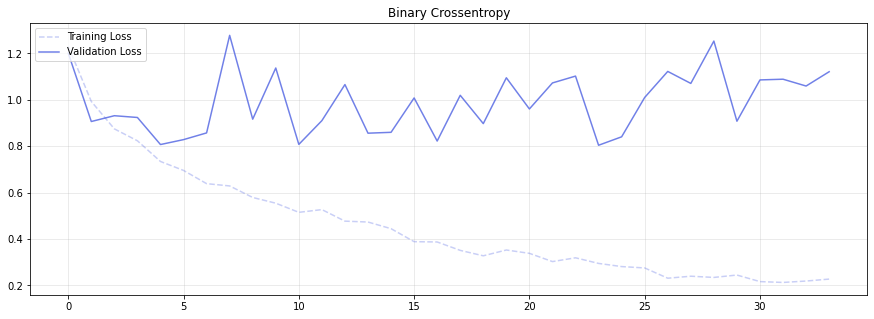

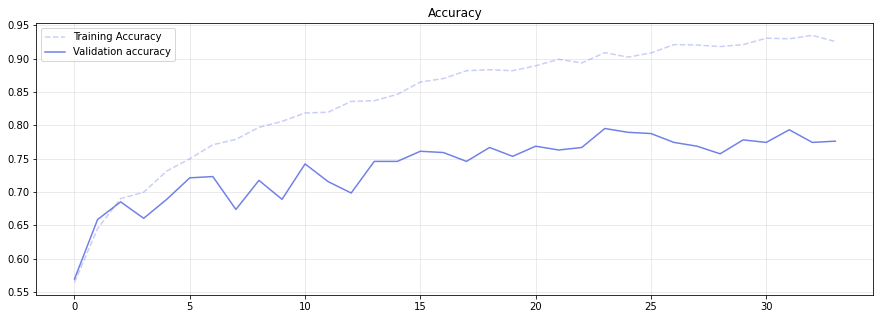

In [24]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [25]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [26]:
tl_model.save('Vgg16/Tuned_v1_1')

In [27]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 58s 5s/step - loss: 0.8665 - accuracy: 0.7535 - precision_1: 0.7788 - recall_1: 0.7313

Test metrics
{'loss': 0.8665323257446289, 'accuracy': 0.7534626126289368, 'precision_1': 0.778761088848114, 'recall_1': 0.7313019633293152}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.7535
Precision: 0.7523
Recall: 0.7316
F1: 0.7341


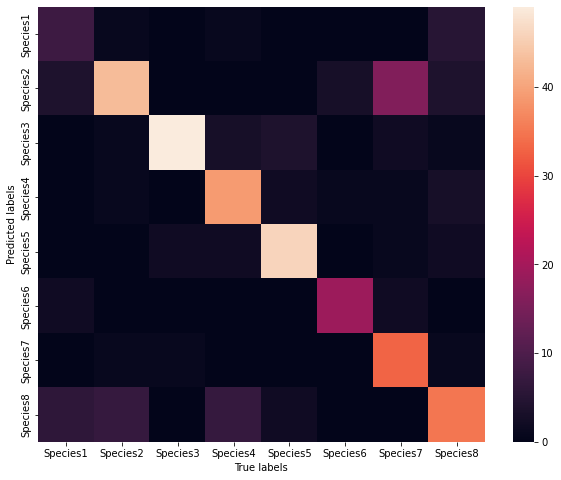

In [28]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()